In [1]:
import os
import os.path as osp

import torch
from torch import nn

from torch_ema import ExponentialMovingAverage


import curriculums
import datasets

from siren import siren
from generators import generators
from discriminators import discriminators

## training options at iteration 0

In [2]:
curriculum = getattr(curriculums, 'CelebA')
curriculum["dataset_path"] = '/media/z/Elements1/data/Face/CelebA/img_align_celeba/*.jpg'
metadata = curriculums.extract_metadata(curriculum, 0)
metadata["batch_size"] = 28 
metadata

{'batch_size': 28,
 'num_steps': 12,
 'img_size': 64,
 'batch_split': 2,
 'gen_lr': 6e-05,
 'disc_lr': 0.0002,
 'dataset_path': '/media/z/Elements1/data/Face/CelebA/img_align_celeba/*.jpg',
 'fov': 12,
 'ray_start': 0.88,
 'ray_end': 1.12,
 'fade_steps': 10000,
 'h_stddev': 0.3,
 'v_stddev': 0.155,
 'h_mean': 1.5707963267948966,
 'v_mean': 1.5707963267948966,
 'sample_dist': 'gaussian',
 'topk_interval': 2000,
 'topk_v': 0.6,
 'betas': (0, 0.9),
 'unique_lr': False,
 'weight_decay': 0,
 'r1_lambda': 0.2,
 'latent_dim': 256,
 'grad_clip': 10,
 'model': 'SPATIALSIRENBASELINE',
 'generator': 'ImplicitGenerator3d',
 'discriminator': 'CCSEncoderDiscriminator',
 'dataset': 'CelebA',
 'clamp_mode': 'relu',
 'z_dist': 'gaussian',
 'hierarchical_sample': True,
 'z_lambda': 0,
 'pos_lambda': 15,
 'last_back': False,
 'eval_last_back': True}

In [3]:
def z_sampler(shape, device, dist):
    if dist == 'gaussian':
        z = torch.randn(shape, device=device)
    elif dist == 'uniform':
        z = torch.rand(shape, device=device) * 2 - 1
    return z

fixed_z = z_sampler((25, 256), device='cpu', dist=metadata['z_dist'])
fixed_z.shape

torch.Size([25, 256])

In [4]:
SIREN = getattr(siren, metadata['model'])
SIREN

siren.siren.SPATIALSIRENBASELINE

In [5]:
S = SIREN(output_dim=4, z_dim=256, input_dim=3, device=None)
S.mapping_network

CustomMappingNetwork(
  (network): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=4608, bias=True)
  )
)

### Siren FiLM Layer: Sine(x*freq + shift)
    freq & shift from mapping network

In [6]:
class FiLMLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.layer = nn.Linear(input_dim, hidden_dim)

    def forward(self, x, freq, phase_shift):
        x = self.layer(x)
        freq = freq.unsqueeze(1).expand_as(x)
        phase_shift = phase_shift.unsqueeze(1).expand_as(x)
        return torch.sin(freq * x + phase_shift)

### Generator layer initialization

In [7]:
# frequency_init(25)
import numpy as np
num_input = 256
freq = 25
"Init Layer", -1 / 3, 1 / 3, "Hidden", -np.sqrt(6 / num_input) / freq, np.sqrt(6 / num_input) / freq

('Init Layer',
 -0.3333333333333333,
 0.3333333333333333,
 'Hidden',
 -0.006123724356957945,
 0.006123724356957945)

In [8]:
scaler = torch.cuda.amp.GradScaler()

## train from scratch

In [9]:
device = "cuda"

In [10]:
generator = getattr(generators, metadata['generator'])(SIREN, metadata['latent_dim']).to(device)
discriminator = getattr(discriminators, metadata['discriminator'])().to(device)
ema = ExponentialMovingAverage(generator.parameters(), decay=0.999)
ema2 = ExponentialMovingAverage(generator.parameters(), decay=0.9999)

In [11]:
metadata['generator'], metadata['latent_dim']

('ImplicitGenerator3d', 256)

In [15]:
discriminator.state_dict()

OrderedDict([('layers.0.network.0.conv.weight',
              tensor([[[[-3.9769e-02, -1.4718e-01,  2.3360e-02],
                        [ 8.2494e-02,  2.0850e-02, -3.1980e-02],
                        [-4.5239e-02,  2.3165e-02,  5.7709e-02]],
              
                       [[-8.8322e-02, -1.0182e-01,  5.1102e-02],
                        [ 1.0118e-01, -5.4839e-02, -2.1347e-02],
                        [-9.1643e-02, -1.6159e-01, -3.0331e-02]],
              
                       [[ 4.6277e-02, -1.4918e-01,  3.6175e-02],
                        [ 9.1609e-02, -2.1022e-02,  4.8069e-02],
                        [ 3.1588e-02, -2.9098e-02,  5.2920e-02]],
              
                       ...,
              
                       [[ 6.5049e-02, -8.1022e-02,  7.8463e-03],
                        [-2.4406e-02,  1.0221e-01, -4.3356e-03],
                        [ 4.3752e-02,  1.2592e-01, -4.9294e-02]],
              
                       [[ 1.7880e-02,  1.9922e-02, -4.2689e-02],


## Generator: 
    * 8 layer siren with ray mapping network and frequency shift

In [28]:
generator

ImplicitGenerator3d(
  (siren): SPATIALSIRENBASELINE(
    (network): ModuleList(
      (0): FiLMLayer(
        (layer): Linear(in_features=3, out_features=256, bias=True)
      )
      (1): FiLMLayer(
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
      (2): FiLMLayer(
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
      (3): FiLMLayer(
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
      (4): FiLMLayer(
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
      (5): FiLMLayer(
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
      (6): FiLMLayer(
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
      (7): FiLMLayer(
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (final_layer): Linear(in_features=256, out_features=1, bias=True)
    (color_layer_sine): FiLMLayer(
      (lay

In [29]:
discriminator

CCSEncoderDiscriminator(
  (layers): ModuleList(
    (0): ResidualCCBlock(
      (network): Sequential(
        (0): CoordConv(
          (addcoords): AddCoords()
          (conv): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): CoordConv(
          (addcoords): AddCoords()
          (conv): Conv2d(66, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (proj): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    )
    (1): ResidualCCBlock(
      (network): Sequential(
        (0): CoordConv(
          (addcoords): AddCoords()
          (conv): Conv2d(66, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): CoordConv(
          (addcoords): AddCoords()
          (conv): Conv2d(130, 128, kernel_size=(3, 3), stride=(2, 2), pad

In [110]:
generator_parameters = generator.parameters()
discriminator_parameters = discriminator.parameters()

if metadata.get('unique_lr', False):
    mapping_network_param_names = [name for name, _ in generator.siren.mapping_network.named_parameters()]
    mapping_network_parameters = [p for n, p in generator.named_parameters() if n in mapping_network_param_names]
    generator_parameters = [p for n, p in generator.named_parameters() if n not in mapping_network_param_names]

    optimizer_G = torch.optim.Adam([{'params': generator_parameters, 'name': 'generator'},
                                    {'params': mapping_network_parameters, 'name': 'mapping_network', 'lr':metadata['gen_lr']*5e-2}],
                                   lr=metadata['gen_lr'], betas=metadata['betas'], weight_decay=metadata['weight_decay'])
else:
    optimizer_G = torch.optim.Adam(generator_parameters, lr=metadata['gen_lr'], betas=metadata['betas'], weight_decay=metadata['weight_decay'])

optimizer_D = torch.optim.Adam(discriminator_parameters, lr=metadata['disc_lr'], betas=metadata['betas'], weight_decay=metadata['weight_decay'])

## if learning rates no unique, mapping network smaller than generator, not the case

In [112]:
metadata.get('unique_lr', False)

False

In [114]:
[name for name, _ in generator.siren.mapping_network.named_parameters()], metadata['gen_lr']*5e-2, metadata['gen_lr']

(['network.0.weight',
  'network.0.bias',
  'network.2.weight',
  'network.2.bias',
  'network.4.weight',
  'network.4.bias',
  'network.6.weight',
  'network.6.bias'],
 3e-06,
 6e-05)

In [115]:
metadata.get('disable_scaler', False)

False

In [116]:
for param_group in optimizer_G.param_groups:
    print(param_group.get('name'))

None


In [126]:
dataloader = None

In [127]:
discriminator.step

0

## For every epoch
    for _ in range (opt.n_epochs):
        total_progress_bar.update(1)

        metadata = curriculums.extract_metadata(curriculum, discriminator.step)

In [129]:
metadata = curriculums.extract_metadata(curriculum, discriminator.step)

In [125]:
# Set learning rates
for param_group in optimizer_G.param_groups:
    if param_group.get('name', None) == 'mapping_network':
        param_group['lr'] = metadata['gen_lr'] * 5e-2
    else:
        param_group['lr'] = metadata['gen_lr']
    param_group['betas'] = metadata['betas']
    param_group['weight_decay'] = metadata['weight_decay']
    print("opt_G " +"\t".join([f"{k}: {param_group[k]}" for k in ["lr", "betas", "weight_decay"]]))
for param_group in optimizer_D.param_groups:
    param_group['lr'] = metadata['disc_lr']
    param_group['betas'] = metadata['betas']
    param_group['weight_decay'] = metadata['weight_decay']
    print("opt_D " +"\t".join([f"{k}: {param_group[k]}" for k in ["lr", "betas", "weight_decay"]]))
    

opt_G lr: 6e-05	betas: (0, 0.9)	weight_decay: 0
opt_D lr: 0.0002	betas: (0, 0.9)	weight_decay: 0


In [133]:
if not dataloader or dataloader.batch_size != metadata['batch_size']:
    dataloader, CHANNELS = datasets.get_dataset(metadata['dataset'], **metadata)

    step_next_upsample = curriculums.next_upsample_step(curriculum, discriminator.step)
    step_last_upsample = curriculums.last_upsample_step(curriculum, discriminator.step)


In [140]:
step_next_upsample, step_last_upsample


(200000, 0)

In [139]:
len(dataloader), len(dataloader)/metadata["batch_size"]

(7235, 258.39285714285717)

In [142]:
scaler.get_scale(), scaler.get_scale() < 1

(65536.0, False)

## train discriminator

    for i, (imgs, _) in enumerate(dataloader):
        if discriminator.step % opt.model_save_interval == 0 and rank == 

In [144]:
# shortcut to get batch
iterator = iter(dataloader)
imgs, what_is_this = next(iterator)

In [146]:
imgs.shape, what_is_this

(torch.Size([28, 3, 64, 64]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]))

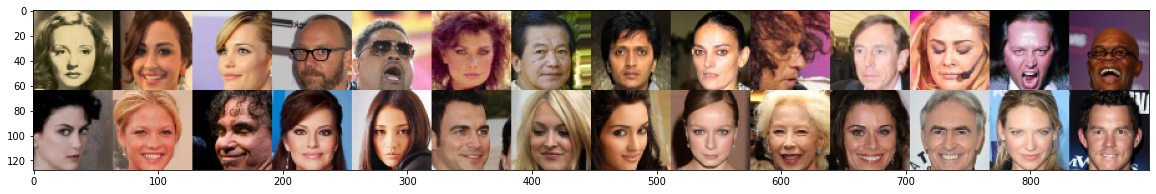

In [154]:
import matplotlib.pyplot as plt

ims = torch.cat((torch.cat([i for i in imgs[:14]], dim=-1).permute(1,2,0),
                 torch.cat([i for i in imgs[14:]], dim=-1).permute(1,2,0)), dim=0).numpy()
plt.figure(figsize=(20,5))
plt.imshow((ims - ims.min())/(ims.max() - ims.min()))
plt.show()

In [ ]:
with torch.cuda.amp.autocast():
    # Generate images for discriminator training
    with torch.no_grad():
        z = z_sampler((real_imgs.shape[0], metadata['latent_dim']), device=device, dist=metadata['z_dist'])
        split_batch_size = z.shape[0] // metadata['batch_split']
        gen_imgs = []
        gen_positions = []
        for split in range(metadata['batch_split']):
            subset_z = z[split * split_batch_size:(split+1) * split_batch_size]
            g_imgs, g_pos = generator(subset_z, **metadata)

            gen_imgs.append(g_imgs)
            gen_positions.append(g_pos)

        gen_imgs = torch.cat(gen_imgs, axis=0)
        gen_positions = torch.cat(gen_positions, axis=0)

    real_imgs.requires_grad = True
    r_preds, _, _ = discriminator(real_imgs, alpha, **metadata)